In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import numpy as np
import pandas as pd

In [3]:
import celloracle as co
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180


In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/day3_lymph_rep_1.h5ad')
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

### Rerun CO if oracle object not saved

In [23]:
sc.tl.pca(adata, svd_solver='arpack')
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p', 'pca'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [24]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

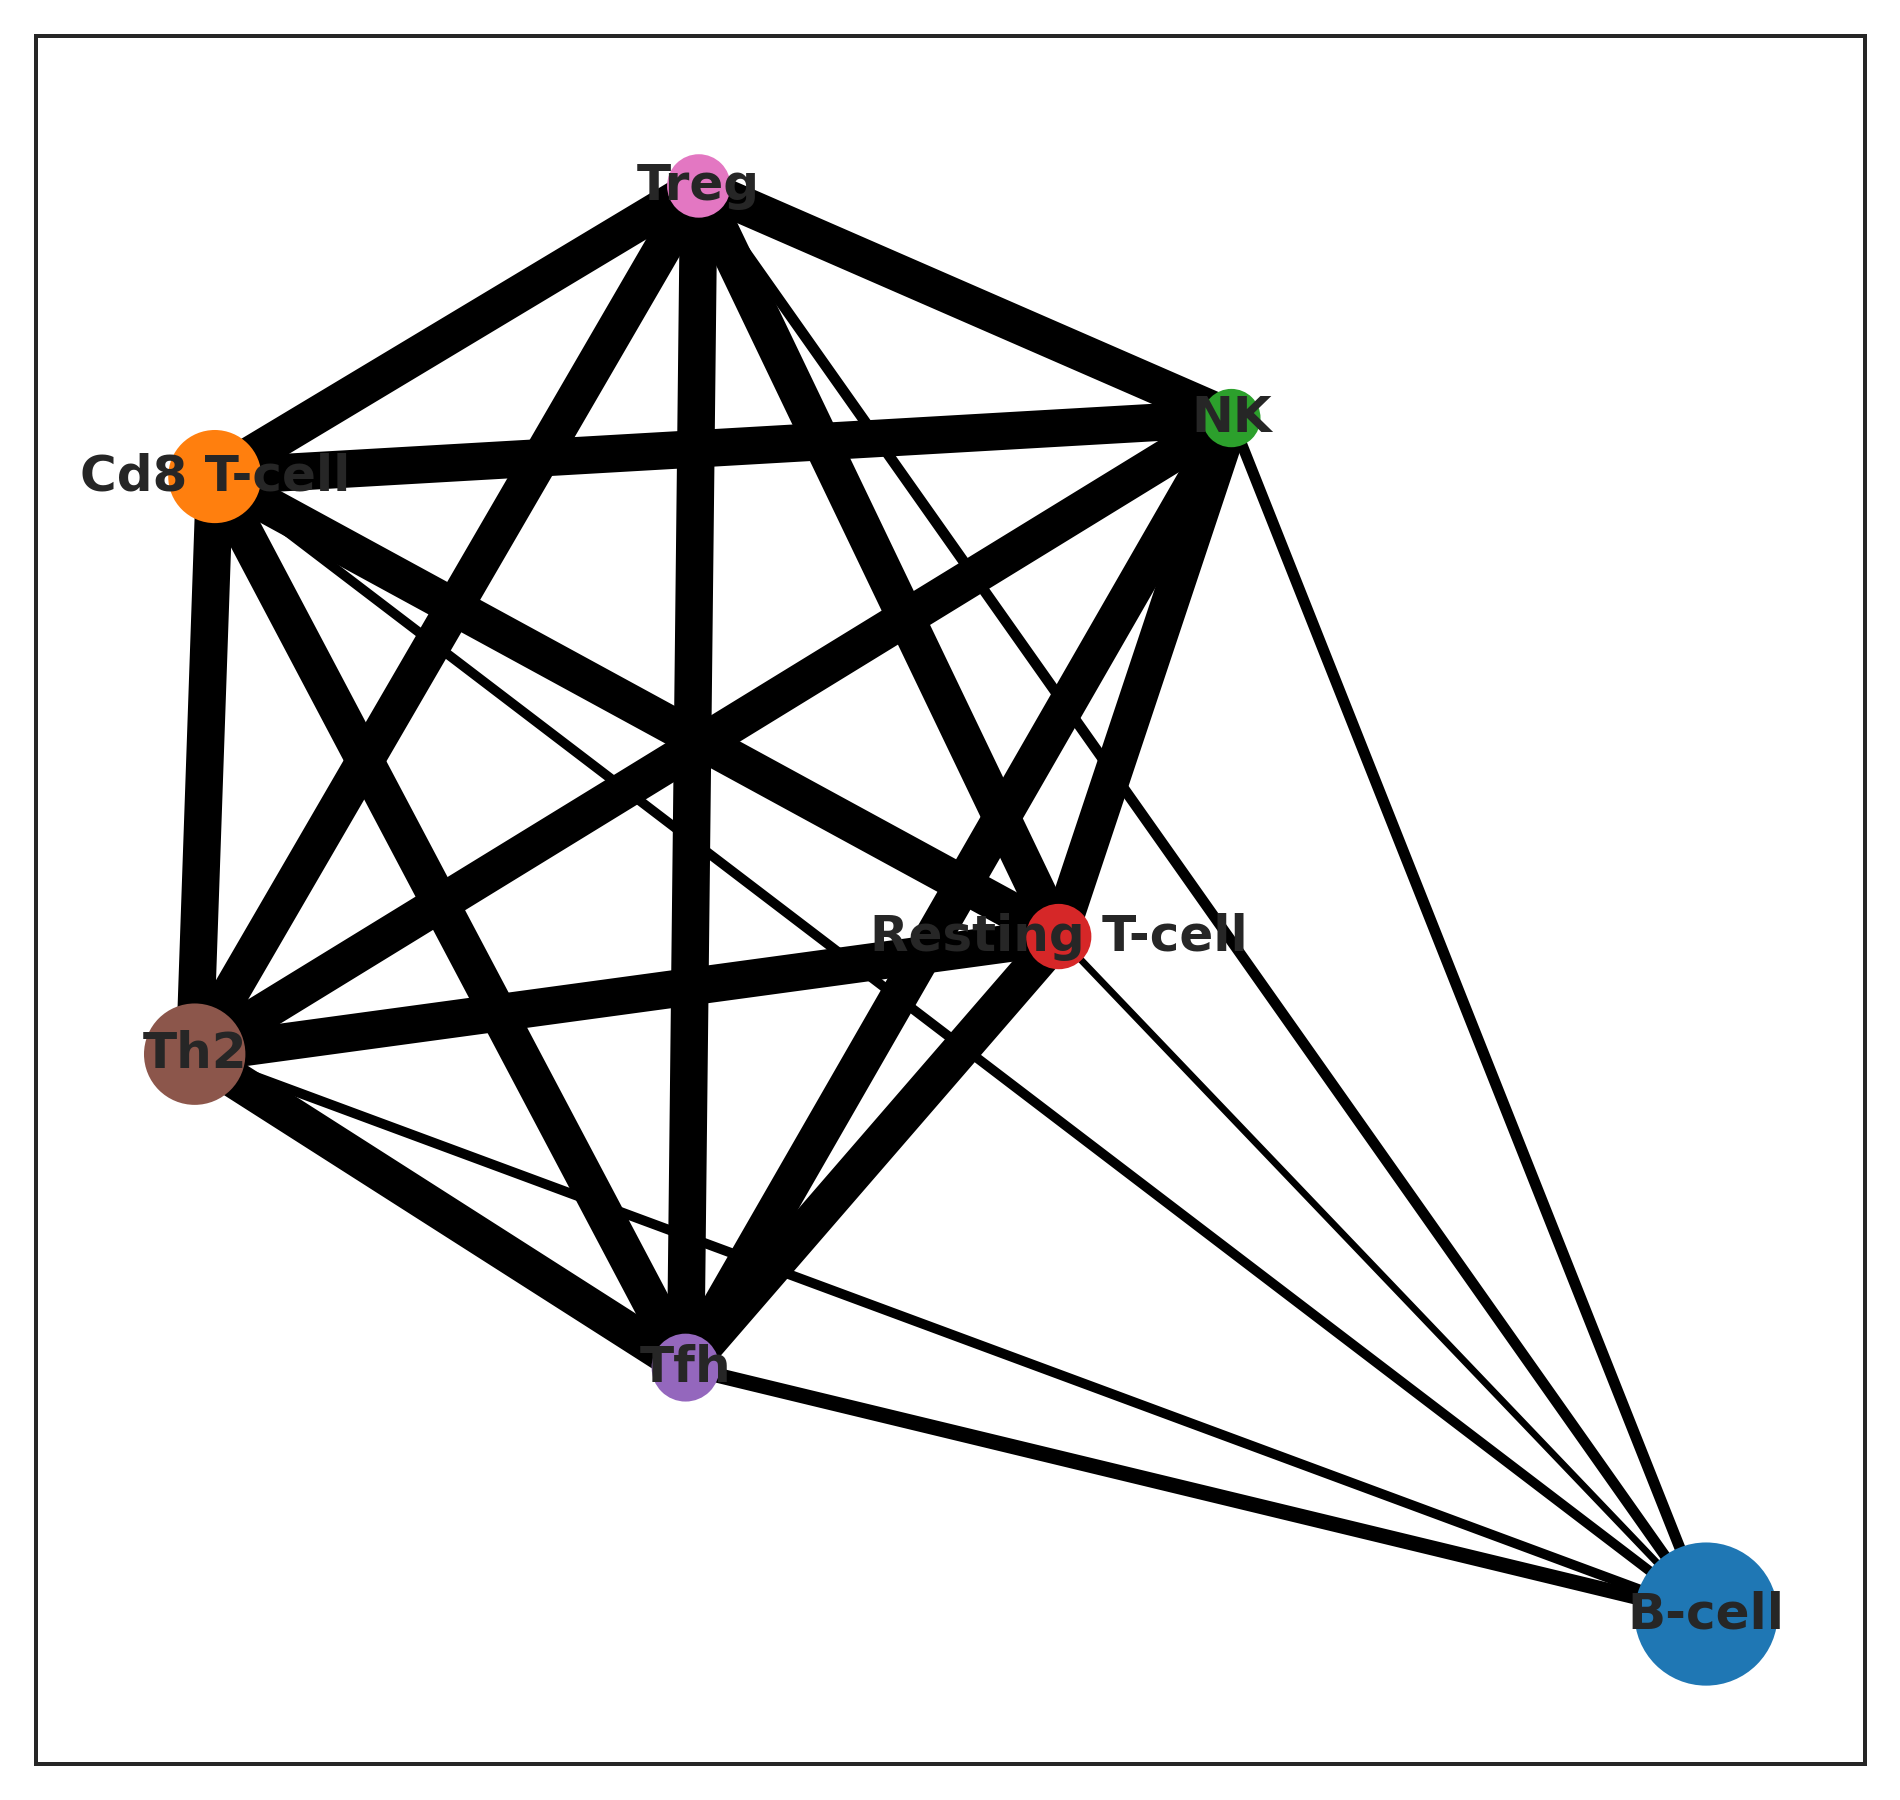

In [27]:
sc.tl.paga(adata, groups='rctd_celltypes')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

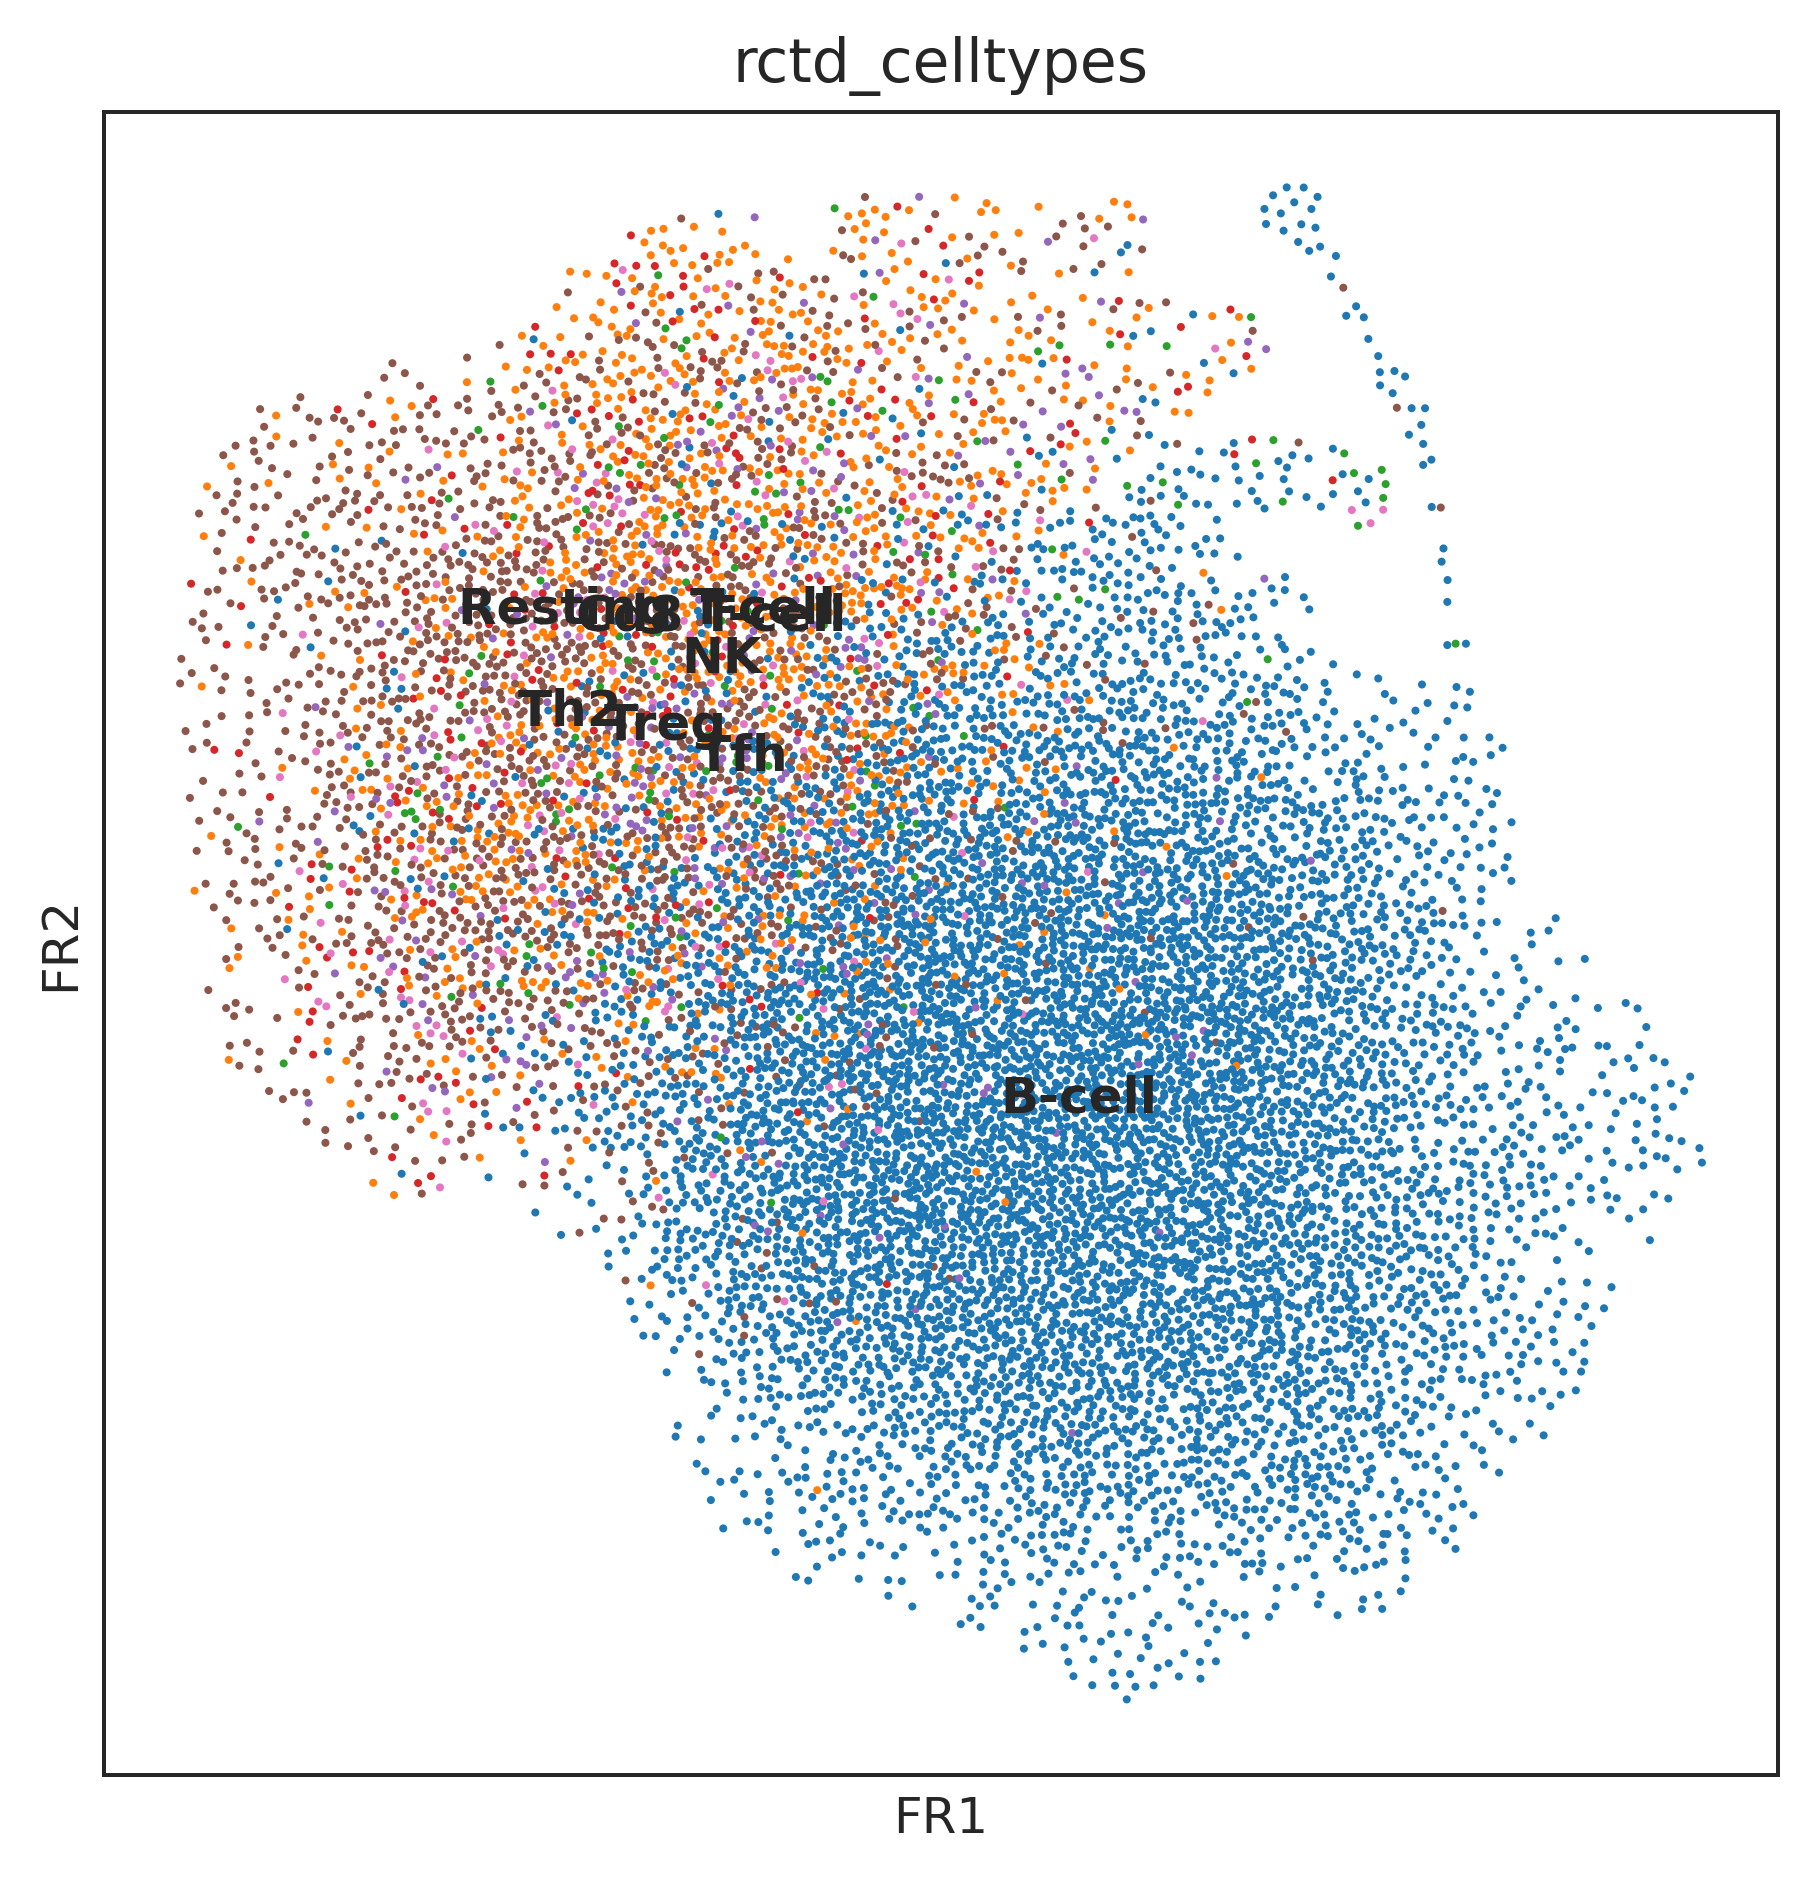

In [28]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='rctd_celltypes', legend_loc='on data')

In [29]:
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'paga', 'rctd_celltypes_sizes', 'rctd_celltypes_colors', 'draw_graph'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [30]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="rctd_celltypes",
                                   embedding_name="X_draw_graph_fr")

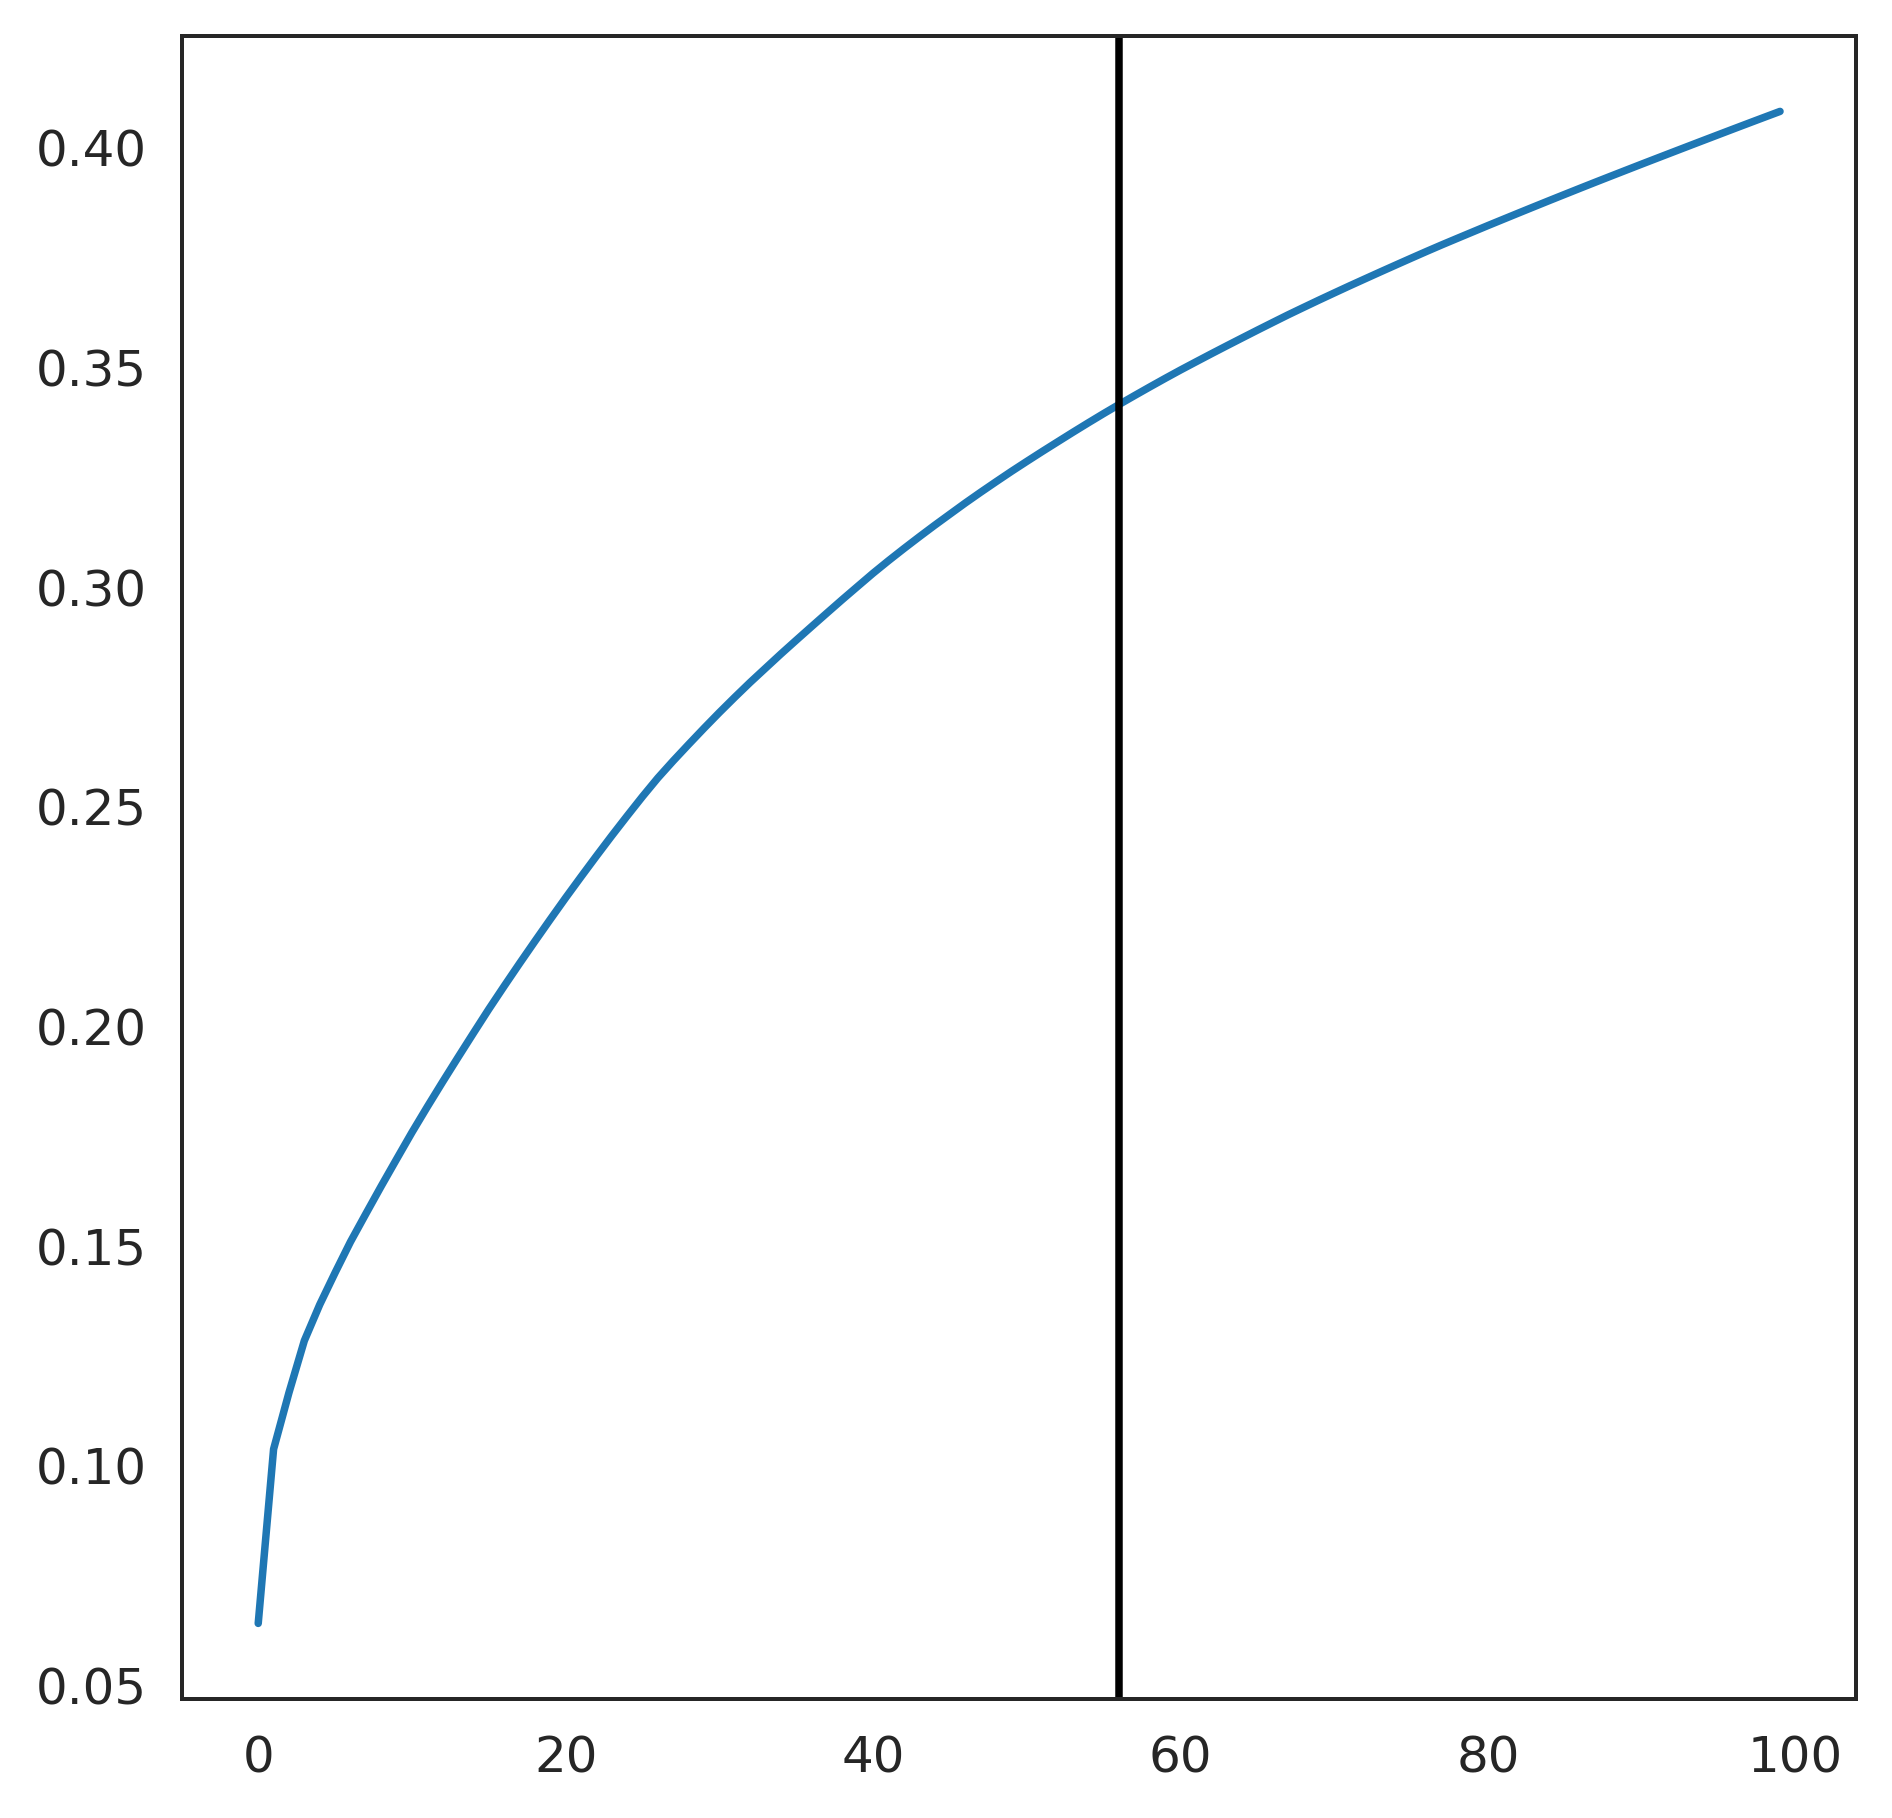

56


In [31]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [32]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :11567
Auto-selected k is :289


In [33]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [34]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [48]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_celltypes", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for B-cell...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Cd8 T-cell...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for NK...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Resting T-cell...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Tfh...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Th2...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Treg...


  0%|          | 0/2405 [00:00<?, ?it/s]

CPU times: user 22min 26s, sys: 3.95 s, total: 22min 30s
Wall time: 49min 51s


In [49]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [50]:
oracle.to_hdf5("../../data/lymph_day3.celloracle.oracle")

In [54]:
links.to_hdf5(file_path="../../data/links.celloracle.links")

### Find macrostate transitions

In [5]:
import sys 
sys.path.append('../../src')

from spaceoracle.prophets import Prophet
from spaceoracle.judges import Judge

In [6]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
co_savedir = results_dir + '/co_simulated'
st_savedir = results_dir + '/st_simulated'

In [8]:
goi = 'Pax5'

# nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
nt_st = pd.DataFrame(adata.layers['imputed_count'], columns=adata.var_names)
# co = pd.DataFrame(np.load(co_savedir + '/Afp.npy'), columns=oracle.adata.var_names)
st = pd.DataFrame(np.load(st_savedir + f'/{goi}.npy'), columns=adata.var_names)

In [9]:
judger = Judge(adata, annot='rctd_celltypes')

st_sim_adata = judger.create_sim_adata(
    ctrl_count=nt_st, 
    ko_count=st
)

In [10]:
%%time
seacells_data = judger.get_macrostates(st_sim_adata, build_kernel_on = 'X_pca')

Getting macrostates...
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/11567 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/11567 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/11567 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 78 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 22/22 [00:01<00:00, 16.76it/s]


Selecting 12 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00198
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 25 iterations.
Getting KO macrostates...
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/11567 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/11567 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/11567 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 70 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 30/30 [00:00<00:00, 34.50it/s]


Selecting 20 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00197
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 26 iterations.
CPU times: user 26min 28s, sys: 35.5 s, total: 27min 4s
Wall time: 40min 46s


In [11]:
st_sim_adata

AnnData object with n_obs × n_vars = 23134 × 3020
    obs: 'status', 'rctd_celltypes'
    var: 'gene'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
wt_ct = 'Th2'
ko_ct = 'B-cell'
mask_wt = seacells_data['wt']['labels'] == wt_ct
mask_ko = seacells_data['ko']['labels'] == ko_ct

In [20]:
mask_wt.values

array([[False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False,  True,  True, False],
       ...,
       [False,  True, False, False, False],
       [ True, False,  True, False, False],
       [False, False,  True,  True, False]])

In [21]:
seacells_data['ko']['weights'][mask_wt.values & mask_ko.values]

array([0.15686275, 0.05254902, 0.03686275, ..., 0.14745098, 0.04313725,
       0.03764706])

In [23]:
sankey_df = judger.get_macrostate_change(st_sim_adata, seacells_data, annot='rctd_celltypes')
sankey_df


,source,target,value
0,B-cell,B-cell,602.567059
1,B-cell,Tfh,2.123137
2,B-cell,Th2,56.843137
3,B-cell,Treg,1.100392
4,B-cell,Cd8 T-cell,12.992157
5,B-cell,Resting T-cell,0.000000
6,B-cell,NK,9.118431
7,Tfh,B-cell,12.436078
8,Tfh,Tfh,0.717647
9,Tfh,Th2,32.280000


In [31]:
import plotly.graph_objects as go
import pandas as pd

# Assume `sankey_df` is your DataFrame with 'source', 'target', and 'value'.
def plot_bipartite_sankey(sankey_df):
    # Add invisible prefixes to distinguish sources and targets
    sankey_df['source_prefixed'] = 'Source_' + sankey_df['source']
    sankey_df['target_prefixed'] = 'Target_' + sankey_df['target']

    # Get unique labels with prefixes
    unique_labels = list(pd.unique(sankey_df[['source_prefixed', 'target_prefixed']].values.ravel('K')))
    label_to_idx = {label: i for i, label in enumerate(unique_labels)}

    # Map sources and targets to indices
    sources = sankey_df['source_prefixed'].map(label_to_idx).tolist()
    targets = sankey_df['target_prefixed'].map(label_to_idx).tolist()
    values = sankey_df['value'].tolist()

    # Remove prefixes for clean display in the legend
    clean_labels = [label.replace('Source_', '').replace('Target_', '') for label in unique_labels]

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=clean_labels,  # Display labels without prefixes
        ),
        link=dict(
            source=sources,  # Indices of source nodes
            target=targets,  # Indices of target nodes
            value=values     # Flow values
        )
    )])

    fig.update_layout(
        title_text="Bipartite Sankey Diagram",
        font_size=10
    )
    fig.show()

# Example usage
# sankey_df = get_macrostate_change(sim_adata, seacells_data, annot)
plot_bipartite_sankey(sankey_df)


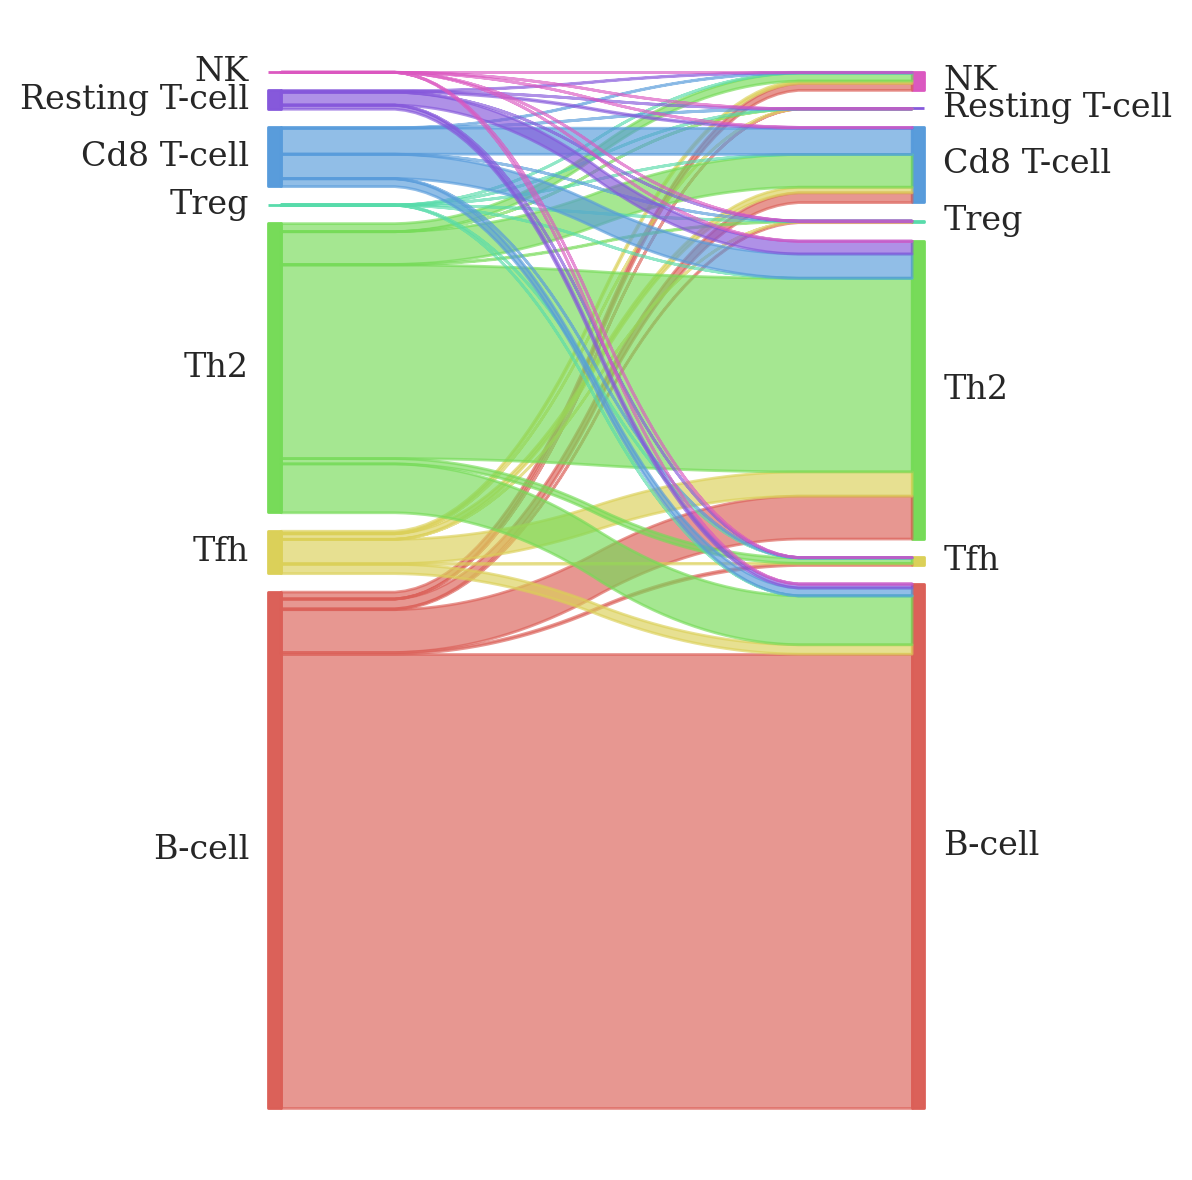

In [43]:
from pySankey.sankey import sankey

def plot_pysankey(sankey_df):
    sankey(
        sankey_df['source'], 
        sankey_df['target'], 
        sankey_df['value'], 
        aspect=20,
        fontsize=12,
        figure_name="Macrostate Change Sankey"
    )

    plt.tight_layout()

# Example usage
plot_pysankey(sankey_df)


### Do comparison

In [5]:
oracle = co.load_hdf5("../../data/lymph_day3.celloracle.oracle")
links = co.load_hdf5(file_path="../../data/links.celloracle.links")

In [6]:
tfs = []
for cluster, df in links.links_dict.items():
    tfs.extend(df["source"].unique())

tfs = sorted(set(tfs))
len(tfs)

102

In [7]:
import sys 
sys.path.append('../../src')

In [8]:
from spaceoracle.prophets import Prophet

pythia = Prophet(
    adata=adata,
    models_dir='/ix/djishnu/shared/djishnu_kor11/models_v2',
    annot='rctd_cluster',
    annot_labels='rctd_celltypes'
)

pythia.compute_betas()

2025-01-16 00:49:51.168326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 2000/2000 [02:37<00:00, 12.69it/s]


In [9]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
co_savedir = results_dir + '/co_simulated'
st_savedir = results_dir + '/st_simulated'

In [ ]:
tf = 'Ar'
print(tf)
pythia.perturb(tf, n_propagation=3)

Ar


Interactions: 100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s]


In [66]:

np.save(st_savedir + f'/{tf}', pythia.adata.layers['simulated_count'])

In [67]:
oracle.simulate_shift(perturb_condition={tf: 0})
np.save(co_savedir + f'/{tf}', oracle.adata.layers['simulated_count'])

In [ ]:
from spaceoracle.judges import Judge
judger = Judge(adata)

2025-01-15 22:59:28.314720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
st_sim_adata = judger.create_sim_adata(
    pythia.adata.layers['imputed_count'], 
    pythia.adata.layers['simulated_count']
)

st_deg_df = judger.get_expected_degs(st_sim_adata, ko=tf, show=30, save_path=results_dir + f'/comparison/degs/{tf}_ST.png')


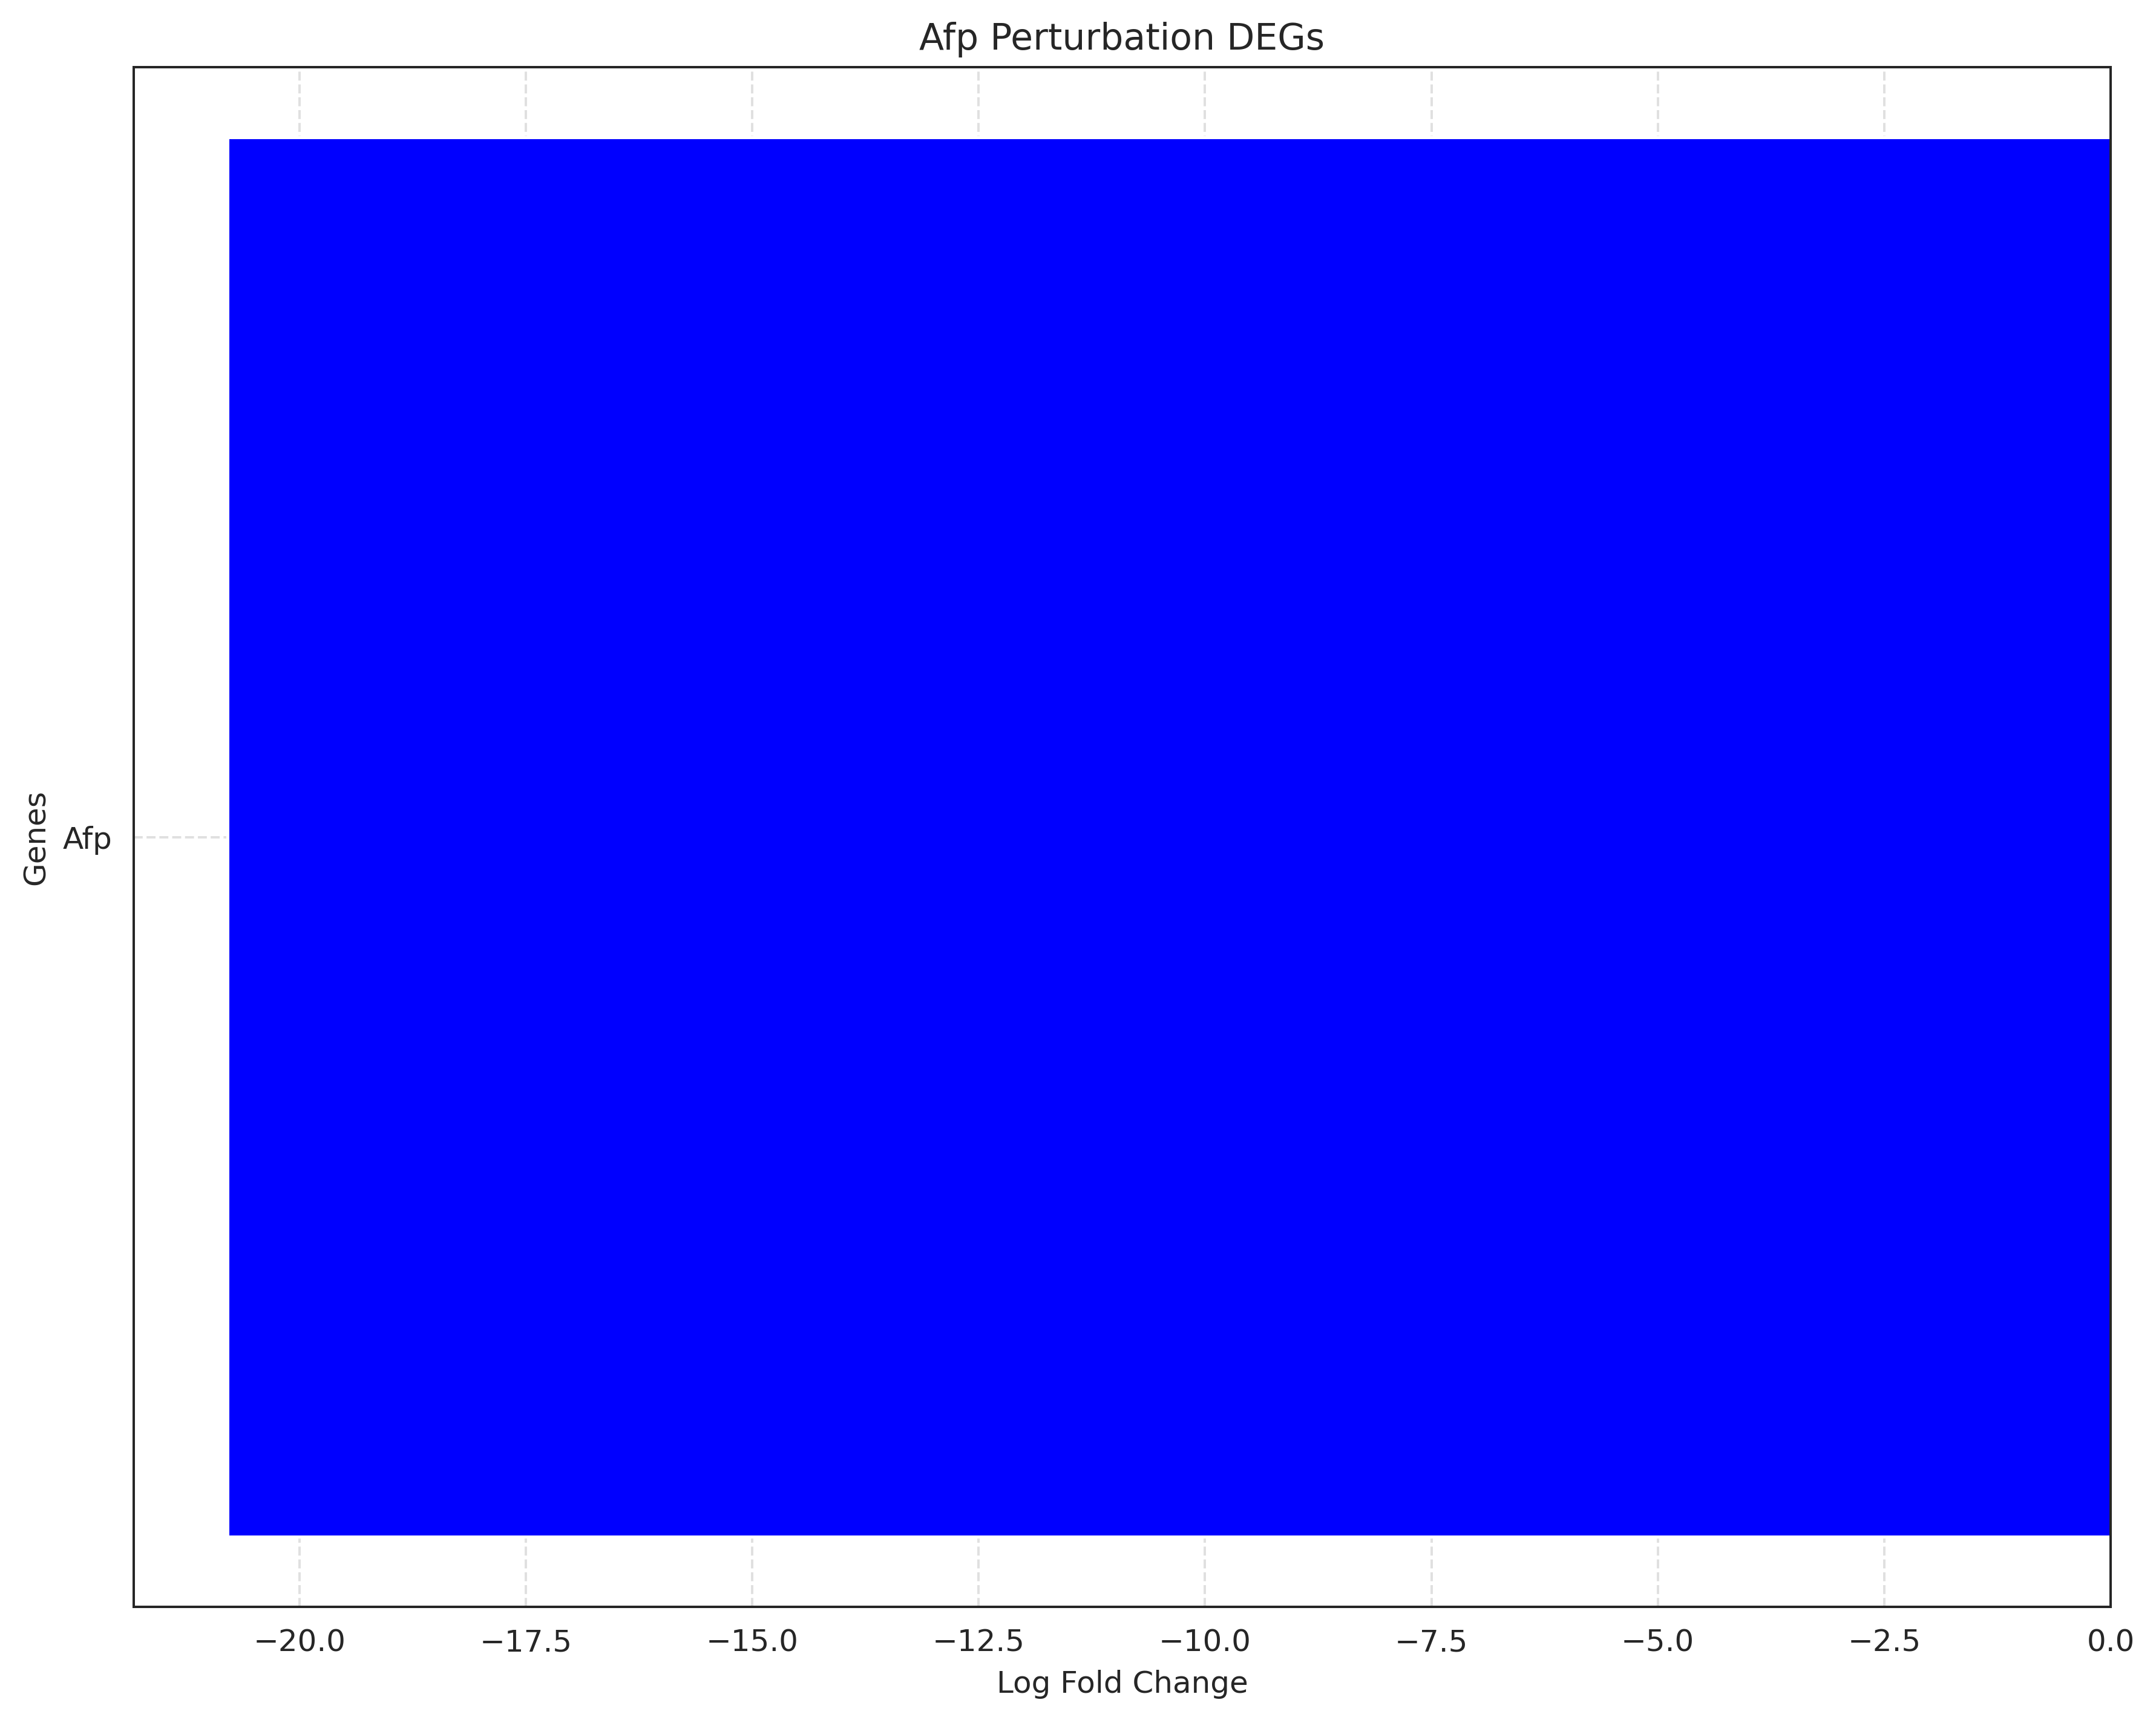

In [103]:
co_sim_adata = judger.create_sim_adata(
    oracle.adata.layers['imputed_count'], 
    oracle.adata.layers['simulated_count']
)

co_deg_df = judger.get_expected_degs(co_sim_adata, tf, show=30, save_path=results_dir + f'/comparison/degs/{tf}_CO.png')

In [104]:
nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
co = pd.DataFrame(oracle.adata.layers['simulated_count'], columns=oracle.adata.var_names)
nt_st = pd.DataFrame(pythia.adata.layers['imputed_count'], columns=oracle.adata.var_names)
st = pd.DataFrame(pythia.adata.layers['simulated_count'], columns=oracle.adata.var_names)

In [6]:
# results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
# co_savedir = results_dir + '/co_simulated'
# st_savedir = results_dir + '/st_simulated'


# nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
# nt_st = pd.DataFrame(adata.layers['imputed_count'], columns=oracle.adata.var_names)
# co = pd.DataFrame(np.load(co_savedir + '/Afp.npy'), columns=oracle.adata.var_names)
# st = pd.DataFrame(np.load(st_savedir + '/Afp.npy'), columns=oracle.adata.var_names)

In [12]:
judger.plot_delta_corr(nt_co=nt_co, co=co, nt_st=nt_st, pred=st, ko=tf, save_path=results_dir + f'/comparison/delta_corr/{tf}.png')

In [50]:
sc.tl.rank_genes_groups(st_sim_adata, 'status', groups=['ko'], reference='wt')
sc.get.rank_genes_groups_df(st_sim_adata, group='ko').sort_values(by='logfoldchanges', ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj
1,Serpine2,1.043780,0.023875,2.965979e-01,1.000000e+00
3,Ap4m1,0.871014,0.010653,3.837553e-01,1.000000e+00
2,Gng12,1.000616,0.008539,3.170229e-01,1.000000e+00
4,Cnr2,0.748656,0.008322,4.540724e-01,1.000000e+00
0,Hars2,1.181826,0.008297,2.372870e-01,1.000000e+00
...,...,...,...,...,...
3015,Fos,-1.221134,-0.023957,2.220476e-01,1.000000e+00
3017,Enpp1,-2.414018,-0.024088,1.578539e-02,1.000000e+00
3018,Efcab2,-3.407428,-0.035639,6.568995e-04,9.919183e-01
3019,Runx1t1,-8.230729,-0.185486,1.958117e-16,5.913514e-13


In [106]:
sc.tl.rank_genes_groups(co_sim_adata, 'status', groups=['ko'], reference='wt')
sc.get.rank_genes_groups_df(co_sim_adata, group='ko').sort_values(by='logfoldchanges', ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Cnr2,0.006216,9.484621e-05,0.995041,1.0
1,Gtf2f1,0.003878,3.697056e-05,0.996906,1.0
2,Spag7,0.003549,3.081760e-05,0.997168,1.0
3,Col4a1,0.000846,1.135680e-05,0.999325,1.0
4,Napsa,0.000030,4.460199e-07,0.999976,1.0
...,...,...,...,...,...
3016,S100a13,-0.005391,-5.077594e-05,0.995699,1.0
3015,Id2,-0.004592,-7.489223e-05,0.996336,1.0
3017,Ppig,-0.008570,-8.915089e-05,0.993162,1.0
3018,Chordc1,-0.014837,-1.496831e-04,0.988162,1.0


In [23]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
co_savedir = results_dir + '/co_simulated'
st_savedir = results_dir + '/st_simulated'


nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
nt_st = pd.DataFrame(adata.layers['imputed_count'], columns=oracle.adata.var_names)
co = pd.DataFrame(np.load(co_savedir + '/Bach2.npy'), columns=oracle.adata.var_names)
st = pd.DataFrame(np.load(st_savedir + '/Bach2.npy'), columns=oracle.adata.var_names)

In [35]:
st['Bach2']

0        0.000894
1        0.000894
2        0.000894
3        0.000894
4        0.000894
           ...   
11562    0.000894
11563    0.000894
11564    0.000894
11565    0.000894
11566    0.000894
Name: Bach2, Length: 11567, dtype: float64

In [34]:
nt_st['Bach2']

0        0.029909
1        0.018250
2        0.038584
3        0.045740
4        0.025813
           ...   
11562    0.025266
11563    0.031116
11564    0.021223
11565    0.032894
11566    0.024923
Name: Bach2, Length: 11567, dtype: float64

In [32]:
(st-nt_st)['Bach2']

0       -0.029016
1       -0.017356
2       -0.037691
3       -0.044847
4       -0.024919
           ...   
11562   -0.024373
11563   -0.030223
11564   -0.020329
11565   -0.032001
11566   -0.024029
Name: Bach2, Length: 11567, dtype: float64